<a href="https://colab.research.google.com/github/MKurseev/master_thesis/blob/main/main_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [ ]:
!pip3 install sentence_transformers

In [2]:
import glob
import os
import pandas as pd

import numpy as np
from tqdm import tqdm

from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss

import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/master_thesis/')

Mounted at /content/gdrive/


___
### Выгрузка данных 

In [4]:
survey_fcasts = pd.DataFrame()

file_type = 'csv'
seperator =','

for f in glob.glob("*." + file_type):
    if f[:13] == 'survey_fcasts':
        data = pd.read_csv(f, sep=seperator, low_memory=False, encoding='ISO-8859-1')
        survey_fcasts = pd.concat([survey_fcasts, data])
    

ifps = pd.read_csv('ifps.csv', sep=seperator, encoding='ISO-8859-1')

In [5]:
survey_fcasts.head(5)

,ifp_id,ctt,cond,training,team,user_id,forecast_id,fcast_type,answer_option,value,fcast_date,expertise,q_status,viewtime,year,timestamp
0,1004-0,1a,1,a,NaN,600.0,-200987.0,0,a,0.10,2011-08-31,1.0,closed,NaN,1,2011-08-31 16:17:18
1,1004-0,1a,1,a,NaN,600.0,-200987.0,0,b,0.90,2011-08-31,1.0,closed,NaN,1,2011-08-31 16:17:18
2,1008-0,1a,1,a,NaN,600.0,-200986.0,0,a,0.25,2011-08-31,2.0,closed,NaN,1,2011-08-31 16:18:27
3,1008-0,1a,1,a,NaN,600.0,-200986.0,0,b,0.75,2011-08-31,2.0,closed,NaN,1,2011-08-31 16:18:27
4,1006-0,1a,1,a,NaN,600.0,-200985.0,0,a,0.10,2011-08-31,3.0,closed,NaN,1,2011-08-31 16:18:47


In [6]:
ifps.head(2)

,ifp_id,q_type,q_text,q_desc,q_status,date_start,date_suspend,date_to_close,date_closed,outcome,short_title,days_open,n_opts,options
0,1001-0,0,"Will the Six-Party talks (among the US, North ...",'In' refers to any time during the remainder o...,closed,9/1/11,12/30/11 0:00,12/31/11,1/2/12,b,Six-party talks resume,123.0,2,"(a) Yes, (b) No"
1,1002-0,0,Who will be inaugurated as President of Russia...,'In' refers to any time during the 2012 calend...,closed,9/1/11,5/14/12 0:00,5/15/12,5/6/12,b,president of Russia,248.0,3,"(a) Medvedev, (b) Putin, (c) Neither"
2,1003-0,0,Will Serbia be officially granted EU candidacy...,A 'yes' answer to this question requires not o...,closed,9/1/11,12/30/11 0:00,12/31/11,1/3/12,b,Serbia EU candidacy,124.0,2,"(a) Yes, (b) No"
3,1004-0,0,Will the United Nations General Assembly recog...,'By' means at or prior to the end of the day o...,closed,9/1/11,9/29/11 0:00,9/30/11,9/30/11,b,UN-GA recognize Palestine,29.0,2,"(a) Yes, (b) No"
4,1005-0,0,Will Daniel Ortega win another term as Preside...,If the Nicaraguan elections do not occur in la...,closed,9/1/11,11/4/11 0:00,11/5/11,11/5/11,a,Ortega win in Nicaragua,65.0,2,"(a) Yes, (b) No"


In [7]:
q_ifps = pd.DataFrame(ifps['q_text'].unique(), columns=['questions'])
unique_q_num = q_ifps.nunique()

# show some of them
(
q_ifps.questions[0], 
q_ifps.questions[391], 
q_ifps.questions[200] 
)

('Will the Six-Party talks (among the US, North Korea, South Korea, Russia, China, and Japan) formally resume in 2011?',
 'Will **national military force(s) from one or more countries *intervene in Syria **before 1 December 2014?',
 'When will Mariano Rajoy vacate the office of Prime Minister of Spain?')

In [8]:
f'Всего вопросов : {unique_q_num[0]}'

'Всего вопросов : 527'

___
### Предсказание людей в зависимости от их ответа в прошлый год

In [9]:
user_answers = survey_fcasts[['ifp_id','user_id','q_status','year','answer_option','timestamp','value','fcast_type','fcast_date']]
user_answers = user_answers[(~user_answers.user_id.isna()) & (user_answers.q_status == 'closed')].reset_index(drop=True)

user_answers['ans_type'] = user_answers.ifp_id.apply(lambda x: x[5:]).astype(int)
user_answers['question'] = user_answers.ifp_id.apply(lambda x: x[:4]).astype(int)

assert user_answers.user_id.apply(lambda x: x.is_integer()).sum() == user_answers.shape[0]

user_answers['user_id'] = user_answers['user_id'].astype(int)
user_answers = user_answers.sort_values(['question','user_id'])

In [10]:
user_answers.head(2)

,ifp_id,user_id,q_status,year,answer_option,timestamp,value,fcast_type,fcast_date,ans_type,question
5555,1001-0,3,closed,1,a,2011-09-06 05:46:12,0.5,1,2011-09-06,0,1001
5556,1001-0,3,closed,1,b,2011-09-06 05:46:12,0.5,1,2011-09-06,0,1001


In [11]:
mask = (ifps.q_status == 'closed') & (ifps.n_opts == 2) & (ifps.q_type == 0)
question_answers = ifps[mask][['ifp_id','outcome','date_closed']]
assert question_answers.ifp_id.nunique() == question_answers.shape[0]

In [12]:
question_answers.head(2)

,ifp_id,outcome,date_closed
0,1001-0,b,1/2/12
2,1003-0,b,1/3/12


### Creating final DataFrame

In [13]:
ans = question_answers.merge(user_answers, on='ifp_id', how='inner').drop(['q_status', 'ans_type', 'question'], axis=1)
ans.timestamp = ans.timestamp.astype('datetime64[ns]')
ans["outcome"] = (ans["outcome"] == "a").astype(int)
ans = ans.query('answer_option == "a"')

ans["date_closed"] = pd.to_datetime(ans["date_closed"]) + pd.Timedelta(days=1)
ans.dropna(subset=["user_id"], inplace = True)

ans["user_id"] = ans["user_id"].astype(int).astype(str)
ans["days_until_closure"] = (ans["date_closed"] - ans["timestamp"]).dt.days

master_data = ans.query("days_until_closure > 15").sort_values('fcast_date').groupby(['ifp_id', 'user_id']).tail(1)

In [ ]:
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
sent_embeddings = model.encode(ifps.q_text)
embedding_df = pd.DataFrame(sent_embeddings)

############
n_topics = 16
############

embedding_pca = preprocessing.StandardScaler().fit_transform(PCA(n_components=n_topics).fit_transform(embedding_df))
embedding_pca_df = pd.DataFrame(embedding_pca)


embedding_df["ifp_id"] = ifps.ifp_id
embedding_pca_df["ifp_id"] = ifps.ifp_id

In [15]:
embedding_df.shape, embedding_pca_df.shape

((617, 769), (617, 17))

768 признаков сократили до 16 

In [16]:
event_outcomes = master_data.groupby("ifp_id").outcome.max().reset_index()
expert_inputs = master_data.pivot(index = "ifp_id", columns = "user_id", values = "value").fillna(0)

In [17]:
master_data['user_id'].nunique()

9040

Всего у нас 9040 людей, отвечавших на вопросы. Чтобы матрица была не такой разряженной, оставим только ремпондентов, ответивших больше чем на 50 вопросов

In [18]:
temp = master_data.groupby('user_id',as_index=False).ifp_id.count()
ids_more_50_q = temp.query('ifp_id > 50')[['user_id']]

expert_inputs = master_data.merge(ids_more_50_q).pivot(index = "ifp_id", columns = "user_id", values = "value").fillna(0)

In [19]:
len(expert_inputs.columns)

1367

Осталось всего 1367 респондентов

## Сравнение двух моделей :
1. **Without text features** - в качестве фичей только предсказания респондентов
2. **With text features** - к фичам предсказаний респондетов еще добавляются кроссы с ембендингами текстов самих вопросов

In [20]:
final_ans_wo_text = pd.merge(expert_inputs, event_outcomes, on="ifp_id")

embedding_pca_df_ = embedding_pca_df.merge(event_outcomes[['ifp_id']], on='ifp_id', how='inner')
final_ans_with_text = pd.DataFrame(expert_inputs.values)

cross_cols = embedding_pca_df_.drop('ifp_id', axis=1).shape[1]
for i in range(cross_cols):
    temp = pd.DataFrame(expert_inputs.reset_index().drop('ifp_id', axis=1).T.values * embedding_pca_df_[i].values).T
    final_ans_with_text = pd.concat([final_ans_with_text, temp],axis=1)
    
final_ans_with_text['ifp_id'] = event_outcomes['ifp_id']
final_ans_with_text = pd.merge(final_ans_with_text, event_outcomes, on="ifp_id")


q_year = user_answers[['ifp_id', 'year']].drop_duplicates('ifp_id')

final_ans_wo_text = final_ans_wo_text.merge(q_year, on='ifp_id', how='inner')
final_ans_with_text = final_ans_with_text.merge(q_year, on='ifp_id', how='inner')

In [21]:
print(final_ans_wo_text.shape)
final_ans_wo_text.head(3)

(278, 1370)


,ifp_id,1000,10043,10049,1009,10151,10208,10212,10256,1034,...,9748,9765,9772,9791,9847,9857,9869,991,outcome,year
0,1001-0,0.00,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0,1
1,1003-0,0.00,0.0,0.0,0.10,0.0,0.0,0.0,0.0,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0,1
2,1004-0,0.75,0.0,0.0,0.40,0.0,0.0,0.0,0.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0,1


In [22]:
print(final_ans_with_text.shape)
final_ans_with_text.head(3)

(278, 23242)


,0,1,2,3,4,5,6,7,8,9,...,1360,1361,1362,1363,1364,1365,1366,ifp_id,outcome,year
0,0.00,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.01,0.10,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.081991,1001-0,0,1
1,0.00,0.0,0.0,0.10,0.0,0.0,0.0,0.0,0.01,0.25,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.177425,1003-0,0,1
2,0.75,0.0,0.0,0.40,0.0,0.0,0.0,0.0,0.25,0.20,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.050025,1004-0,0,1


1367 + 1367 * 16  = 23239 признаков

## Обучение моделей с Кросс-валидацией и grid-search (для стабильности)

$$ 
ElasticNetMSE = MSE(y, y_{pred}) + С \cdot (1 - L_{1}Ratio) \sum_{i=1}^{m} \lvert{\theta_{i}}\rvert +  С \cdot (1 - L_{1}Ratio)\sum_{i=1}^{m} \lvert{\theta_{i}}\rvert ,
$$

Where hyperparameters:

* `C` -  This parameter signifies strength of the regularization and takes a positive float value.
* `l1_ratio` -  the penalty will be a combination of l1 & l2, l1_ratio fraction will define the weight of l1 in the mix.
* `penalty` - elasticnet : penalty only supported by: saga solver.
* `solver` - Saga is a variant of Sag and it can be used with l1 Regularization. It’s a quite time-efficient solver and usually the go-to solver with very large datasets.



In [23]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

In [24]:
X_train_wo_text = final_ans_wo_text.query('year != 4').drop(['ifp_id', 'outcome', 'year'], axis=1)
X_test_wo_text = final_ans_wo_text.query('year == 4').drop(['ifp_id', 'outcome', 'year'], axis=1)

y_train_wo_text = final_ans_wo_text.query('year != 4')['outcome']
y_test_wo_text = final_ans_wo_text.query('year == 4')['outcome']

In [25]:
X_train_with_text = final_ans_with_text.query('year != 4').drop(['ifp_id', 'outcome', 'year'], axis=1)
X_test_with_text = final_ans_with_text.query('year == 4').drop(['ifp_id', 'outcome', 'year'], axis=1)

y_train_with_text = final_ans_with_text.query('year != 4')['outcome']
y_test_with_text = final_ans_with_text.query('year == 4')['outcome']

In [26]:
scaler = StandardScaler()
scaler.fit(X_train_with_text)

X_train_with_text_sc = scaler.transform(X_train_with_text)
X_test_with_text_sc = scaler.transform(X_test_with_text)

In [27]:
## проверка что целевая переменная одна и та же 
assert any(y_test_with_text == y_test_wo_text) and any(y_train_wo_text == y_train_with_text)

In [28]:
(y_test_wo_text.count(), y_test_wo_text.mean()), (y_train_wo_text.count(), y_train_wo_text.mean())

((82, 0.21951219512195122), (196, 0.2193877551020408))

В обучающей выборке 196 вопросов, из них 22% имеют ответ yes (outcome = 1) и 78% ответ No (outcome = 0)

В тестовой выборке 82 вопроса, из них 22% имеют ответ yes (outcome = 1) и 78% ответ No (outcome = 0)

---
Выборки стратифицированны и мы имеем задачу бинарной классификации с дисбалансом классов!

In [29]:
skf = StratifiedKFold(n_splits=4)
k_fold = KFold(n_splits=4)

parameters_wo_t = {
    'C'         : np.geomspace(0.005, 1, 10),
    'penalty'   : ['elasticnet'], 
    'solver'    : ['saga'],    
    'l1_ratio'  : [0.33, 0.66],
}

parameters_with_t = {
    'C'         : np.geomspace(0.01, 0.15, 10),
    'penalty'   : ['elasticnet'], 
    'solver'    : ['saga'],    
    'l1_ratio'  : [0.33, 0.66],
}

In [30]:
%%time
lr = LogisticRegression(max_iter= 200, 
                        random_state=12, 
                        n_jobs=-1, 
                        class_weight='balanced',
                        )

clf_wo_text = GridSearchCV(lr, parameters_wo_t, cv=skf, scoring='neg_brier_score')
clf_with_text = GridSearchCV(lr, parameters_with_t, cv=skf, scoring='neg_brier_score')

clf_wo_text.fit(X_train_wo_text, y_train_wo_text)
clf_with_text.fit(X_train_with_text_sc, y_train_with_text)

CPU times: user 31.6 s, sys: 18.6 s, total: 50.3 s
Wall time: 16min 6s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight='balanced', max_iter=200,
                                          n_jobs=-1, random_state=12),
             param_grid={'C': array([0.01      , 0.01351067, 0.01825381, 0.02466212, 0.03332017,
       0.04501778, 0.06082202, 0.08217461, 0.11102338, 0.15      ]),
                         'l1_ratio': [0.33, 0.66], 'penalty': ['elasticnet'],
                         'solver': ['saga']},
             scoring='neg_brier_score')

In [31]:
def plot_res(
    
    plot_data : pd.DataFrame, 
    name      : 'str',
    ax,

) -> None:
    plot_res = pd.DataFrame(plot_data.cv_results_)
    l_1 = plot_res.param_l1_ratio.unique().tolist()

    plt.title(f'{name}', fontsize=16, loc='left')

    for l1 in l_1:
      plt.plot(
          plot_res.query('param_l1_ratio == @l1')['param_C'],
          -plot_res.query('param_l1_ratio == @l1')['mean_test_score'],
          label = f'l1 ratio = {l1}',
          )

    plt.scatter(plot_data.best_params_['C'], -plot_data.best_score_, color='red', linewidths=5, alpha=1)

    plt.xlabel('C regularizaton parameter', fontsize=14)
    plt.ylabel('Brier Score', fontsize=14)
    plt.grid()
    plt.legend()

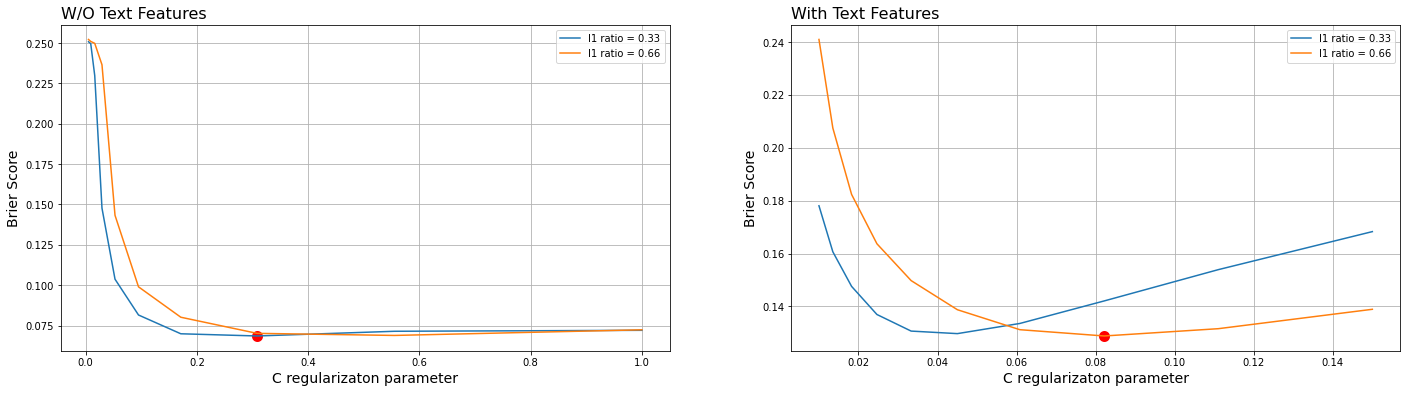

In [32]:
fig = plt.figure(figsize=(24, 6))

for i in [0, 1]:
    plot_res((clf_wo_text, clf_with_text)[i], ('W/O Text Features', 'With Text Features')[i], ax= plt.subplot(1, 2, i+1))

---
#### Prediction in Test sample

In [33]:
y_prob = clf_wo_text.predict_proba(X_test_wo_text)[:,1]
brier_score_loss(y_test_wo_text, y_prob)

0.054400455789512296

In [34]:
y_prob = clf_with_text.predict_proba(X_test_with_text_sc)[:,1]
brier_score_loss(y_test_with_text, y_prob)

0.08757878374632663